Etivity5
John OReilly

In [27]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [28]:
df = pd.read_csv("./insurance.csv")
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [29]:
df.tail()

age  gender     bmi  children smoker     region  insurance_cost
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

In [11]:
print('Gender counts:\n',df['gender'].value_counts(),'\n')
print('Smoker counts:\n',df['smoker'].value_counts(),'\n')
print('Region counts:\n',df['region'].value_counts(),'\n')

Gender counts:
 male      676
female    662
Name: gender, dtype: int64 

Smoker counts:
 no     1064
yes     274
Name: smoker, dtype: int64 

Region counts:
 southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64 



In [12]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

In [13]:
df.describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

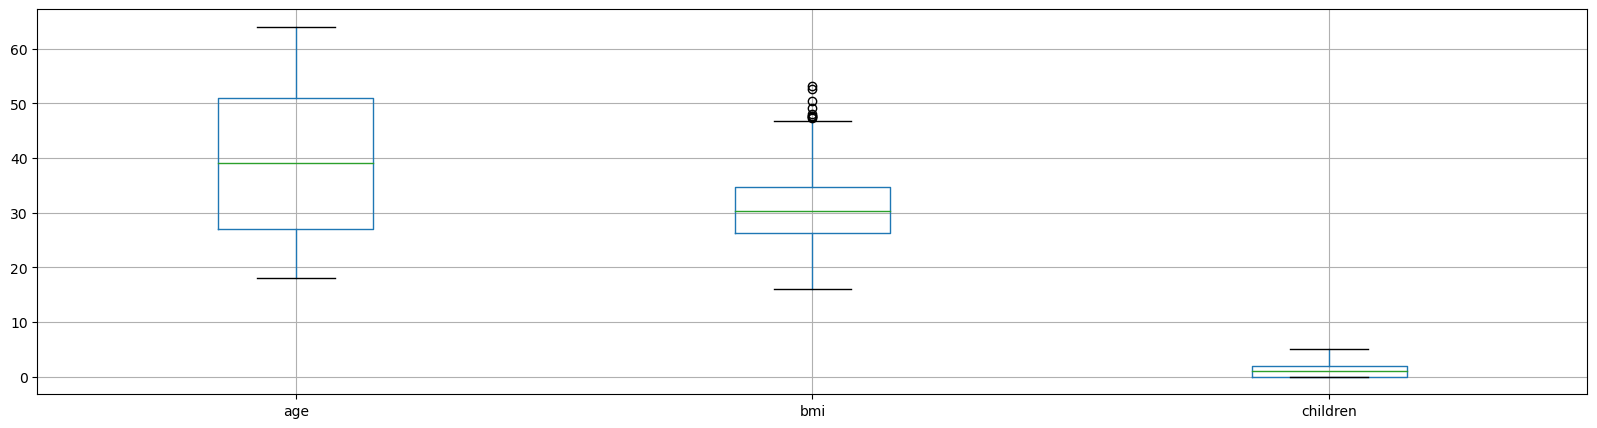

In [14]:
df.drop('insurance_cost', axis=1).boxplot(figsize=(20,5))
plt.show()

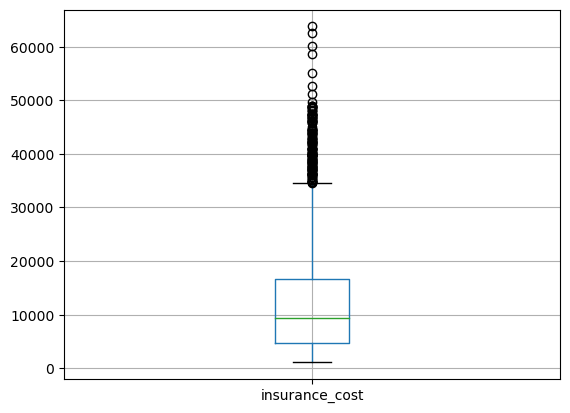

In [15]:
df.boxplot(column=['insurance_cost'])
plt.show()

I'm not going to scale or treat outliers on the target as this may well distort results.

In [30]:
df = pd.get_dummies(df, columns=(['gender','smoker', 'region']),
                        #dummy_na=True, 
                        drop_first=True)

In [31]:
df.head()

age     bmi  children  insurance_cost  gender_male  smoker_yes  \
0   18  33.770         1      1725.55230            1           0   
1   18  34.100         0      1137.01100            1           0   
2   18  26.315         0      2198.18985            0           0   
3   18  38.665         2      3393.35635            0           0   
4   18  35.625         0      2211.13075            0           0   

   region_northwest  region_southeast  region_southwest  
0                 0                 1                 0  
1                 0                 1                 0  
2                 0                 0                 0  
3                 0                 0                 0  
4                 0                 0                 0

I'm not going to treat extreme values of 'bmi' as outliers as I believe they lie within a reasonable range (bmi of 55 is quite possible), so will apply `StandardScaler` to all predictor columns in a simple pre-rpocessing pipeline.

In [32]:
preprocess_pipeline = make_pipeline(StandardScaler())

Now separate the columns into *target* and *predictors* and split the dataset into a training and test sets. 

In [33]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
X_test

In [34]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['insurance_cost']]
print(names_all)
names_outliers = ['insurance_cost']
names_no_outliers = list(set(names_all) - set(names_outliers))

['age', 'bmi', 'children', 'gender_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']


In [35]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

Really simple pipeline, since I'm just going to use standard scaler on everything but the target.

In [46]:

# Fit the pipeline to the training data
X_train_scaled = preprocess_pipeline.fit_transform(X_train)
# Transform the test data using the fitted pipeline to ensure consistancy 
X_test_scaled = preprocess_pipeline.transform(X_test)
print(X_test_scaled.shape)

(268, 8)


Have a look

In [49]:
pipe = Pipeline([
    ('preprocessor', preprocess_pipeline),
    ('reduce_dim', PCA()),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [51]:
N_FEATURES_OPTIONS = [2, 4, 6]
MAX_DEPTH_OPTIONS = [2, 4, 6]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regressor__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regressor__max_depth': MAX_DEPTH_OPTIONS
    }
]

# Perform the grid search
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.853:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regressor__max_depth': 4}


In [57]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regression', LinearRegression())])

In [60]:
# FutureWarning: 'normalize' was deprecated in version 1.0
import warnings
warnings.filterwarnings('ignore', message=".*'normalize' was deprecated in version 1.0*", category=FutureWarning)

In [61]:
N_FEATURES_OPTIONS = [2, 4, 6]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regression__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regression__normalize': NORMALIZE_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.732:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regression__normalize': False}


The results suggest that Random Forest performs better. The cross-validation score is `1 - relative squared error`. The higher the score the more accurate the model. We can now further confirm this by comparing the best models on the test set.

## Compare Regression Models on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their metrics:

- mean squared error (MSE)
- mean absolute error (MAE)
- 1-relative squared error (R2)

to choose the better regressor for our problem.

In [62]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

In [63]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)

Using Pandas bar plots to compare the results. 

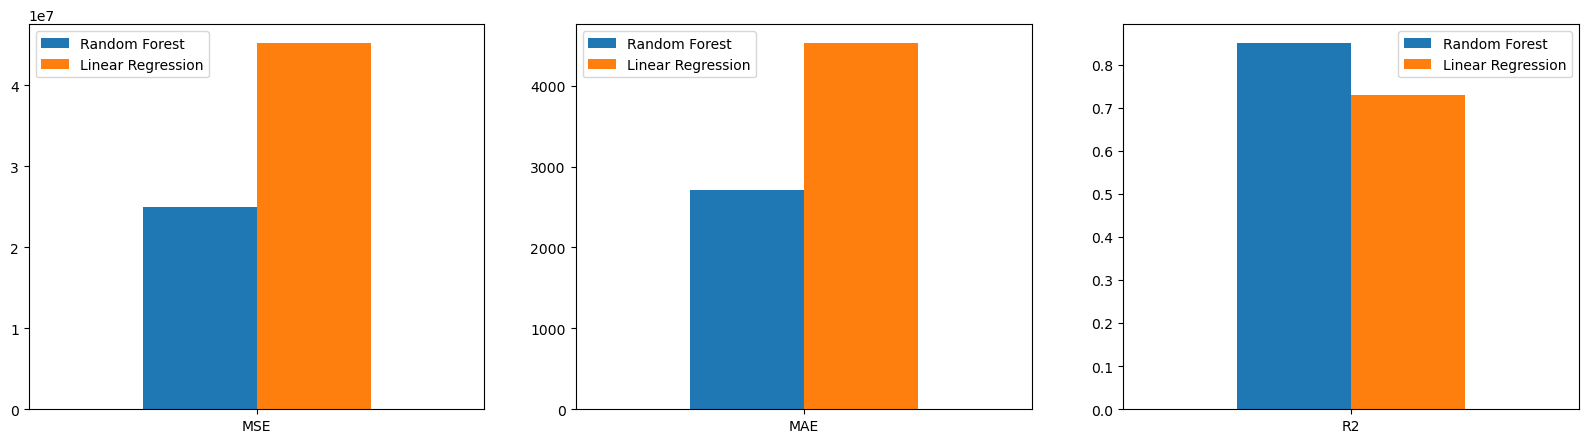

In [64]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

# Task 3
Add two dimensionality-reduction methods which are not used in CS5062 - Lab5 

For this task I'm going to try KNeighborsRegressor and GradientBoostingRegressor

In [94]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import TruncatedSVD

In [97]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regression', KNeighborsRegressor())])

In [100]:

N_NEIGHBORS_OPTIONS = [2,4,8,10]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regression': [KNeighborsRegressor()],
        'regression__n_neighbors': N_NEIGHBORS_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto'))],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regression': [KNeighborsRegressor()],
        'regression__n_neighbors': N_NEIGHBORS_OPTIONS
    },
    {
        'reduce_dim': [RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regression': [KNeighborsRegressor()],
        'regression__n_neighbors': N_NEIGHBORS_OPTIONS
    },
]
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
KNR_best_params = search.best_params_
KNR_best_model = search.best_estimator_

Best CV score = 0.823:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=4), 'reduce_dim__n_features_to_select': 4, 'regression': KNeighborsRegressor(n_neighbors=10), 'regression__n_neighbors': 10}


Try with  TruncatedSVD dimensionality reduction

In [101]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reduce_dim', 'passthrough'), 
    ('regressor', KNeighborsRegressor())
])

N_FEATURES_OPTIONS = [2, 4, 6]
N_NEIGHBORS_OPTIONS = [3, 5, 7, 10]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    },
    {
        'reduce_dim': [TruncatedSVD()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
KNR_best_params = search.best_params_
KNR_best_model = search.best_estimator_

Best CV score = 0.763:
Best parameters:  {'reduce_dim': PCA(iterated_power=7, n_components=6), 'reduce_dim__n_components': 6}


Try GradientBoostRegressor

In [82]:
from sklearn.ensemble import GradientBoostingRegressor

In [83]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regression', GradientBoostingRegressor())])

In [85]:

N_ESTIMATORS_OPTIONS = [10, 50, 100]
LEARNING_RATE_OPTIONS = [0.01, 0.1, 0.5]
MAX_DEPTH_OPTIONS = [2, 3, 4]
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regression': [GradientBoostingRegressor()],
        'regression__n_estimators': N_ESTIMATORS_OPTIONS,
        'regression__learning_rate': LEARNING_RATE_OPTIONS,
        'regression__max_depth': MAX_DEPTH_OPTIONS,
    }
]
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
GBR_best_params = search.best_params_
GBR_best_model = search.best_estimator_

Best CV score = 0.763:
Best parameters:  {'reduce_dim': PCA(iterated_power=7, n_components=6), 'reduce_dim__n_components': 6, 'regression': GradientBoostingRegressor(max_depth=4), 'regression__learning_rate': 0.1, 'regression__max_depth': 4, 'regression__n_estimators': 100}


In [87]:
KNR_mse, KNR_mae, KNR_r2 = evaluate_model(X_test, y_test, KNR_best_model)
GBR_mse, GBR_mae, GBR_r2 = evaluate_model(X_test, y_test, GBR_best_model)

Plot these metrics using pandas.

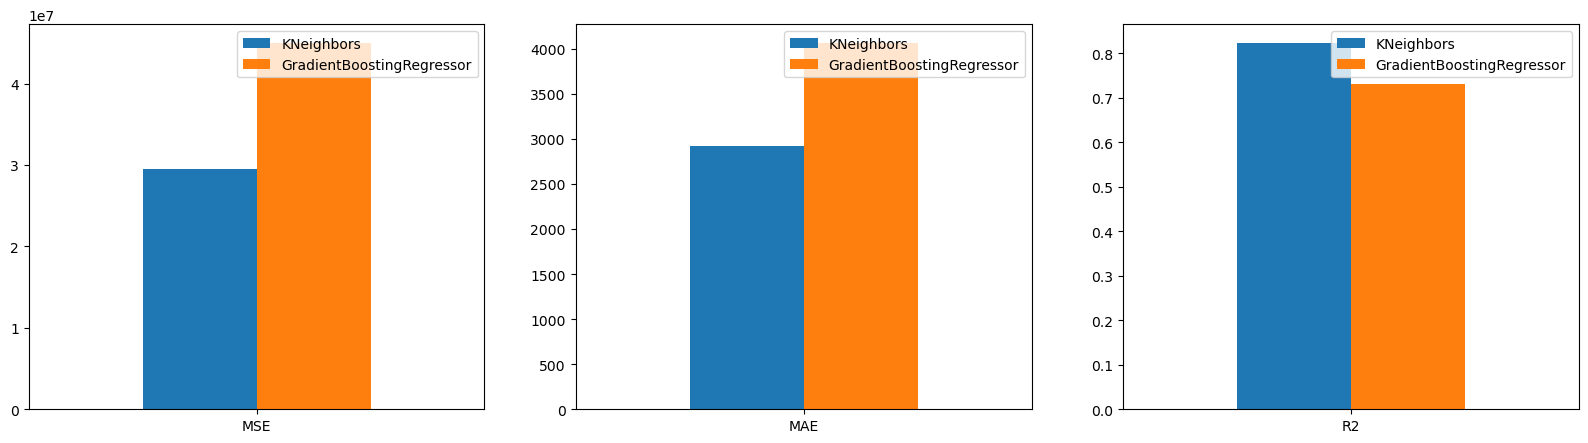

In [89]:
df_mse = pd.DataFrame({'KNeighbors': KNR_mse, 'GradientBoostingRegressor': GBR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'KNeighbors': KNR_mae, 'GradientBoostingRegressor': GBR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'KNeighbors': KNR_r2, 'GradientBoostingRegressor': GBR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

<b>Mean Squared Error</b> (MSE): The MSE is the average of the squared differences between the actual and predicted values. A lower MSE value indicates better performance of the model MSE tends to be sensitive to outliers. Here we see that the KNeighbors model has a clear advantage over GradientBoost and compares well with the RandomForest seen earlier.<br />
<b>Mean Absolute Error</B> (MAE): The MAE is the average of the absolute differences between the actual and predicted values. It is less sensitive to outliers, and again a lower vlaue indicates better performance. Here also we see KNeighbors performs better and compares well with the previously seen RandomForest.<br/>
<b>Coefficient of Determination</b> (R2): The R2 metric measures the proportion of variance in the target that is explained by the model. It ranges from 0 to 1, where 1 indicates that the model perfectly predicts the target and a value of 0 suggests that the model performs no better than just taking the mean of the target variable. Here again we see that KNeighbors performs better on this dataset with the given parameters and preprossing.<br/><br/>
Overall, we see that the Linear Regression model just has the edge over KNeighbors, and I will use this for the final model.

## Train a Final Model
Finally, we can train a linear regression model with all the data we have, assuming that the more data we have the better the model.

In [93]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}


pipe = make_pipeline(preprocess_pipeline, 
                    LR_best_params.get('reduce_dim'),
                    LinearRegression(**transform(LR_best_params, 'regresson__')))



final_model =pipe.fit(X, y)

Model can be saved to disk

In [ ]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))